**Step 1: Installations and Imports**

In [1]:
!pip install nlp
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 1.7 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
print('Tensorflow version', tf.__version__) # Check Tensorflow Version

Tensorflow version 2.9.2


**Step 2: Get the Dataset**

In [4]:
# https://huggingface.co/datasets/emotion
from datasets import load_dataset

dataset = load_dataset("emotion")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

**Step 2.1: Isolate the training set, validation set and test set**

In [6]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

**Step 2.2: View a tweet and its associated label**

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [8]:
train_tweets, train_labels = get_tweet(train)

In [9]:
train_tweets[0], train_labels[0]

('i didnt feel humiliated', 0)

**Step 3: Tokenization**

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(train_tweets)

In [12]:
tokenizer.texts_to_sequences([train_tweets[0]])

[[2, 139, 3, 679]]

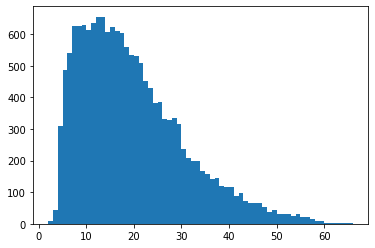

In [13]:
lengths = [len(x.split(' ')) for x in train_tweets]
plt.hist(lengths, bins = len(set(lengths)))
plt.show()

**Step 4: Get sequences**

In [14]:
maxlength = 50

from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlength)
  return padded

In [15]:
padded_train_seq = get_sequences(tokenizer, train_tweets)
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [16]:
classes = set(train_labels)
print(classes)

{0, 1, 2, 3, 4, 5}


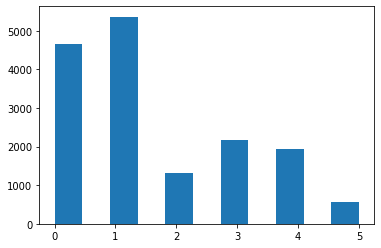

In [17]:
plt.hist(train_labels, bins=11)
plt.show()

In [18]:
# If the classes were in textual form, you'd do the below to convert them to numerical representations
# class_to_index = dict((c, i) for i, c in enumerate(classes))
# index_to_class = dict((v, k) for k, v in class_to_index.items())
# class_to_index
# index_to_class
# names_to_ids = lambda labels: np.array([class_to_index.get(x) for x in labels])
# train_labels = names_to_ids(labels)
# print(train_labels[0])

**Step 5: Create a model**

In [19]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length=maxlength),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [21]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)

In [22]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

**Step 6: Train the Model**

In [23]:
h = model.fit(
    padded_train_seq, np.array(train_labels), 
    validation_data = (val_seq, np.array(val_labels)),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 18s 15ms/step - loss: 1.2996 - accuracy: 0.4782 - val_loss: 0.7313 - val_accuracy: 0.7555
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.5132 - accuracy: 0.8284 - val_loss: 0.5582 - val_accuracy: 0.8135
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3162 - accuracy: 0.8951 - val_loss: 0.5019 - val_accuracy: 0.8285
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2470 - accuracy: 0.9199 - val_loss: 0.4562 - val_accuracy: 0.8515
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1785 - accuracy: 0.9467 - val_loss: 0.4515 - val_accuracy: 0.8695
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.1554 - accuracy: 0.9536 - val_loss: 0.4565 - val_accuracy: 0.8640
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1265 - accuracy: 0.9617 - val_loss: 0.4498 - val_accuracy: 0.87

**Step 7: Plot the metrics: Accuracy and Loss**

In [24]:
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16, 6))

  plt.subplot(1,2,1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

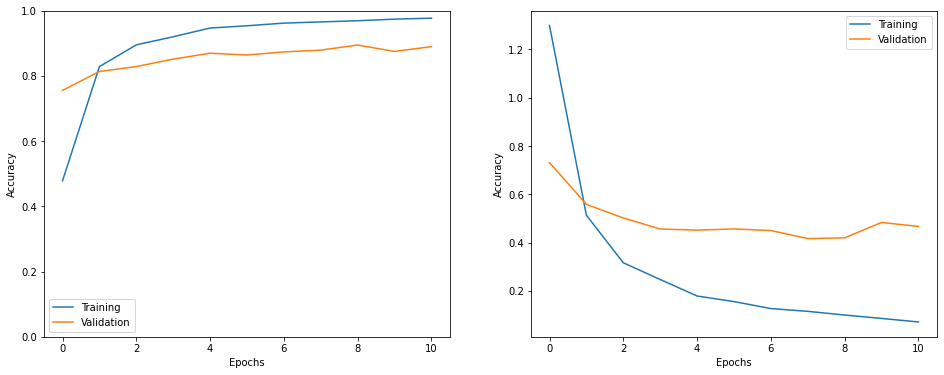

In [25]:
show_history(h)

**Step 8: Evaluate the model on the Test set**

In [26]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)

In [27]:
_ = model.evaluate(test_seq, np.array(test_labels))

63/63 [==============================] - 0s 6ms/step - loss: 0.4108 - accuracy: 0.8895


**Step 9: Make a Prediction**

**Remember** Data fields in the dataset are:



1. text: a string feature.
2. label: a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5).

**Step 9.1: Create a dictionary to map out the emotions on the labels**

In [28]:
emotions_dict = {0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

In [29]:
index_to_class = dict((v, k) for k, v in emotions_dict.items())
index_to_class

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}

**Step 9.2: Make the Prediction**

In [30]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence: ', test_tweets[i])
print('Emotion: ', test_labels[i])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
idx_posn_of_val_with_highest_prediction_score = np.argmax(p)

print('Predicted Emotion: ', {i for i in index_to_class if index_to_class[i]==idx_posn_of_val_with_highest_prediction_score})

Sentence:  i decide that picking the easy route would get me nowhere and i feel like other people want me tortured so i follow the blue path
Emotion:  4
1/1 [==============================] - 1s 1s/step
Predicted Emotion:  {'fear'}


In [31]:
preds = np.argmax(model.predict(test_seq), axis=-1)

63/63 [==============================] - 0s 5ms/step


**Step 10: Create a Confusion Matrix**

<Figure size 576x576 with 0 Axes>

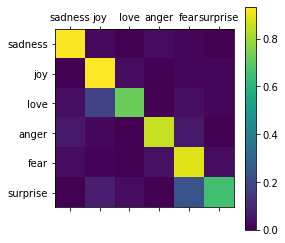

In [32]:
def show_confusion_matrix(y_true, y_pred, classes):
  from sklearn.metrics import confusion_matrix
  cm = confusion_matrix(y_true, y_pred, normalize='true')
  plt.figure(figsize=(8,8))
  ctx = plt.matshow(cm)
  plt.xticks(list(range(0,6)), labels=classes)
  plt.yticks(list(range(0,6)), labels=classes)
  plt.colorbar(ctx)
  plt.show()

# get list of classes as string values from the keys of 'index_to_class' dictionary
classes_list = list(index_to_class.keys())

show_confusion_matrix(test_labels, preds, classes_list)